In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from timm.layers.drop import DropPath
from timm.layers.weight_init import trunc_normal_

import numpy as np
import matplotlib.pyplot as plt
import os, subprocess
import pandas as pd

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

/export/scratch1/home/melle/micromamba/envs/visioncnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format

    def forward(self, x):
        if self.data_format == "channels_last":
            return nn.functional.layer_norm(
                x, (x.shape[-1],), self.weight, self.bias, self.eps
            )
        elif self.data_format == "channels_first":
            mean = x.mean(1, keepdim=True)
            var = (x - mean).pow(2).mean(1, keepdim=True)
            x = (x - mean) / torch.sqrt(var + self.eps)
            return self.weight[:, None, None] * x + self.bias[:, None, None]
        else:
            raise NotImplementedError

class GRN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(dim))
        self.beta = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        # x: (N, H, W, C)
        gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)
        nx = gx / (gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * nx) + self.beta + x


In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 256

trainsetSVHN = torchvision.datasets.SVHN(root='./data', split='train',
                                        download=True, transform=transform)
trainsetCIFAR10 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testsetSVHN = torchvision.datasets.SVHN(root='./data', split='test',
                                       download=True, transform=transform)
testsetCIFAR10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classesSVHN = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
classesCIFAR10 = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset = trainsetCIFAR10
testset = testsetCIFAR10

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=16, pin_memory=True)
classes = classesCIFAR10


Using downloaded and verified file: ./data/train_32x32.mat
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat
Files already downloaded and verified


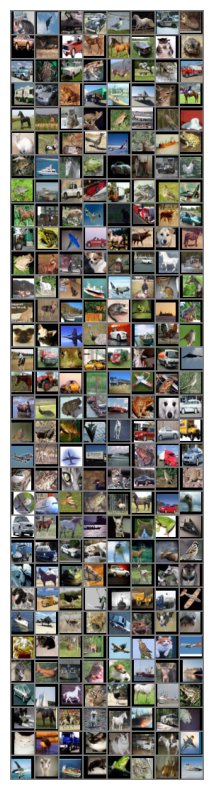

cat plane plane car bird horse car cat car deer car horse horse car cat frog truck frog car frog deer horse cat truck truck car frog truck ship plane deer horse horse deer cat cat frog plane bird dog cat bird deer bird plane deer ship frog frog ship horse frog car cat car bird frog ship car car truck frog bird plane horse horse deer bird cat truck deer car truck frog plane car horse deer dog horse frog deer bird dog truck car horse ship plane deer cat ship plane deer cat horse cat dog ship deer cat frog ship frog dog dog plane bird car ship bird bird horse truck frog car truck cat truck plane horse truck car deer truck plane frog bird deer bird frog truck ship frog dog car bird frog frog plane dog car car truck plane deer plane truck ship frog truck car car frog cat bird cat car bird frog bird plane bird frog deer horse car bird car horse horse ship dog cat frog plane truck car car dog bird deer deer bird plane horse frog horse car deer horse cat dog truck bird deer ship truck truck pl

In [4]:
def imshow(img):
    img = img * 0.5 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images and first digit label
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:>2s}' for j in range(batch_size)))


In [5]:
class Net(nn.Module):
    """Improved 5-layer CNN with batch norm and dropout"""
    def __init__(self, num_classes=10):
        super().__init__()
        # Reduced to ~1.5M parameters (half of ConvNeXt)
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.bn4(self.fc1(x))))
        x = self.fc2(x)
        return x

net = Net()

In [6]:
class Block(nn.Module):
    """ ConvNeXtV2 Block.
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
    """
    def __init__(self, dim, drop_path=0.):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.grn = GRN(4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x
    
convnext = Block(64)


In [7]:
# ConvNeXt-style model using Block architecture
class ConvNeXtModel(nn.Module):
    def __init__(self, in_chans=3, num_classes=10, depths=[2, 2, 2], dims=[80, 160, 320], drop_path_rate=0.1):
        super().__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList()
        
        # Stem layer - adjusted for CIFAR10's small 32x32 images
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=3, stride=2, padding=1),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        
        # Downsampling layers
        for i in range(len(depths) - 1):
            downsample_layer = nn.Sequential(
                LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)
        
        # Stage blocks
        self.stages = nn.ModuleList()
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(len(depths)):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]
        
        # Head
        self.norm = LayerNorm(dims[-1], eps=1e-6, data_format="channels_first")
        self.head = nn.Linear(dims[-1], num_classes)
        
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        for i in range(len(self.depths)):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        
        x = self.norm(x)
        x = x.mean([-2, -1])  # Global average pooling
        x = self.head(x)
        return x

# Create the ConvNeXt model
convnext_model = ConvNeXtModel()

In [8]:
# Training function with improvements for faster and better training
def train_model(model, model_name, epochs=30, lr=0.001, use_scheduler=True, use_mixed_precision=True):
    model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    # Cosine annealing scheduler for better convergence
    if use_scheduler:
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    
    # Mixed precision training for speed (optional)
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    print(f"Training {model_name}...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Learning rate: {lr}, Scheduler: {use_scheduler}, Mixed Precision: {use_mixed_precision}")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        epoch_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            
            if use_mixed_precision:
                # Mixed precision forward pass
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                # Mixed precision backward pass
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard forward and backward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item()
            epoch_loss += loss.item()
            
            # Track training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            if i % 50 == 49:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}, lr: {optimizer.param_groups[0]["lr"]:.6f}')
                running_loss = 0.0
        
        # Store epoch metrics
        train_losses.append(epoch_loss / len(trainloader))
        train_accuracies.append(100 * correct_train / total_train)
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                if use_mixed_precision:
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)
        print(f'Epoch {epoch + 1}: Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_acc:.2f}%\n')
        
        # Step the scheduler
        if use_scheduler:
            scheduler.step()
    
    print(f'Finished Training {model_name}')
    torch.save(model.state_dict(), f'./models/CIFAR10_{model_name}.pth')
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }

In [9]:
# Check parameter counts for fair comparison
net_temp = Net()
convnext_temp = ConvNeXtModel()

net_params = sum(p.numel() for p in net_temp.parameters())
convnext_params = sum(p.numel() for p in convnext_temp.parameters())

print("="*60)
print("MODEL ARCHITECTURE COMPARISON")
print("="*60)
print(f"\nNet (5-layer CNN):")
print(f"  Parameters: {net_params:,}")
print(f"\nConvNeXt (Block architecture):")
print(f"  Parameters: {convnext_params:,}")
print(f"\nParameter ratio: {convnext_params/net_params:.2f}x")
print("="*60)

MODEL ARCHITECTURE COMPARISON

Net (5-layer CNN):
  Parameters: 2,475,530

ConvNeXt (Block architecture):
  Parameters: 2,486,410

Parameter ratio: 1.00x


In [10]:
# Train both models with improved settings
# Set use_mixed_precision=False if you don't want to use mixed precision training
net = Net()
results_net = train_model(net, 'Net', epochs=25, lr=0.001, use_mixed_precision=True)

Training Net...
Model parameters: 2,475,530
Learning rate: 0.001, Scheduler: True, Mixed Precision: True


/tmp/ipykernel_3109134/3235817330.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None


/tmp/ipykernel_3109134/3235817330.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[1,    50] loss: 1.771, lr: 0.001000
[1,   100] loss: 1.523, lr: 0.001000
[1,   150] loss: 1.425, lr: 0.001000


/tmp/ipykernel_3109134/3235817330.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1: Train Acc: 53.57%, Test Acc: 64.06%

[2,    50] loss: 1.287, lr: 0.000996
[2,   100] loss: 1.247, lr: 0.000996
[2,   150] loss: 1.221, lr: 0.000996
Epoch 2: Train Acc: 67.96%, Test Acc: 67.42%

[3,    50] loss: 1.165, lr: 0.000984
[3,   100] loss: 1.156, lr: 0.000984
[3,   150] loss: 1.148, lr: 0.000984
Epoch 3: Train Acc: 72.43%, Test Acc: 71.17%

[4,    50] loss: 1.112, lr: 0.000965
[4,   100] loss: 1.098, lr: 0.000965
[4,   150] loss: 1.093, lr: 0.000965
Epoch 4: Train Acc: 75.29%, Test Acc: 75.67%

[5,    50] loss: 1.064, lr: 0.000938
[5,   100] loss: 1.057, lr: 0.000938
[5,   150] loss: 1.050, lr: 0.000938
Epoch 5: Train Acc: 77.27%, Test Acc: 76.23%

[6,    50] loss: 1.027, lr: 0.000905
[6,   100] loss: 1.013, lr: 0.000905
[6,   150] loss: 1.022, lr: 0.000905
Epoch 6: Train Acc: 79.19%, Test Acc: 76.08%

[7,    50] loss: 0.990, lr: 0.000865
[7,   100] loss: 0.981, lr: 0.000865
[7,   150] loss: 0.989, lr: 0.000865
Epoch 7: Train Acc: 80.50%, Test Acc: 76.69%

[8,    50] l

In [12]:
convnext_model = ConvNeXtModel()
results_convnext = train_model(convnext_model, 'ConvNeXt', epochs=25, lr=0.0005, use_mixed_precision=True)

Training ConvNeXt...
Model parameters: 2,486,410
Learning rate: 0.0005, Scheduler: True, Mixed Precision: True


/tmp/ipykernel_3109134/3235817330.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None
/tmp/ipykernel_3109134/3235817330.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[1,    50] loss: 2.032, lr: 0.000500
[1,   100] loss: 1.864, lr: 0.000500
[1,   150] loss: 1.797, lr: 0.000500


/tmp/ipykernel_3109134/3235817330.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1: Train Acc: 36.54%, Test Acc: 46.30%

[2,    50] loss: 1.675, lr: 0.000498
[2,   100] loss: 1.664, lr: 0.000498
[2,   150] loss: 1.612, lr: 0.000498
Epoch 2: Train Acc: 47.49%, Test Acc: 51.04%

[3,    50] loss: 1.563, lr: 0.000492
[3,   100] loss: 1.519, lr: 0.000492
[3,   150] loss: 1.470, lr: 0.000492
Epoch 3: Train Acc: 54.02%, Test Acc: 57.20%

[4,    50] loss: 1.430, lr: 0.000482
[4,   100] loss: 1.415, lr: 0.000482
[4,   150] loss: 1.386, lr: 0.000482
Epoch 4: Train Acc: 59.37%, Test Acc: 61.63%

[5,    50] loss: 1.358, lr: 0.000469
[5,   100] loss: 1.321, lr: 0.000469
[5,   150] loss: 1.321, lr: 0.000469
Epoch 5: Train Acc: 62.67%, Test Acc: 64.38%

[6,    50] loss: 1.286, lr: 0.000452
[6,   100] loss: 1.268, lr: 0.000452
[6,   150] loss: 1.264, lr: 0.000452
Epoch 6: Train Acc: 65.66%, Test Acc: 67.25%

[7,    50] loss: 1.222, lr: 0.000432
[7,   100] loss: 1.227, lr: 0.000432
[7,   150] loss: 1.210, lr: 0.000432
Epoch 7: Train Acc: 68.30%, Test Acc: 69.92%

[8,    50] l

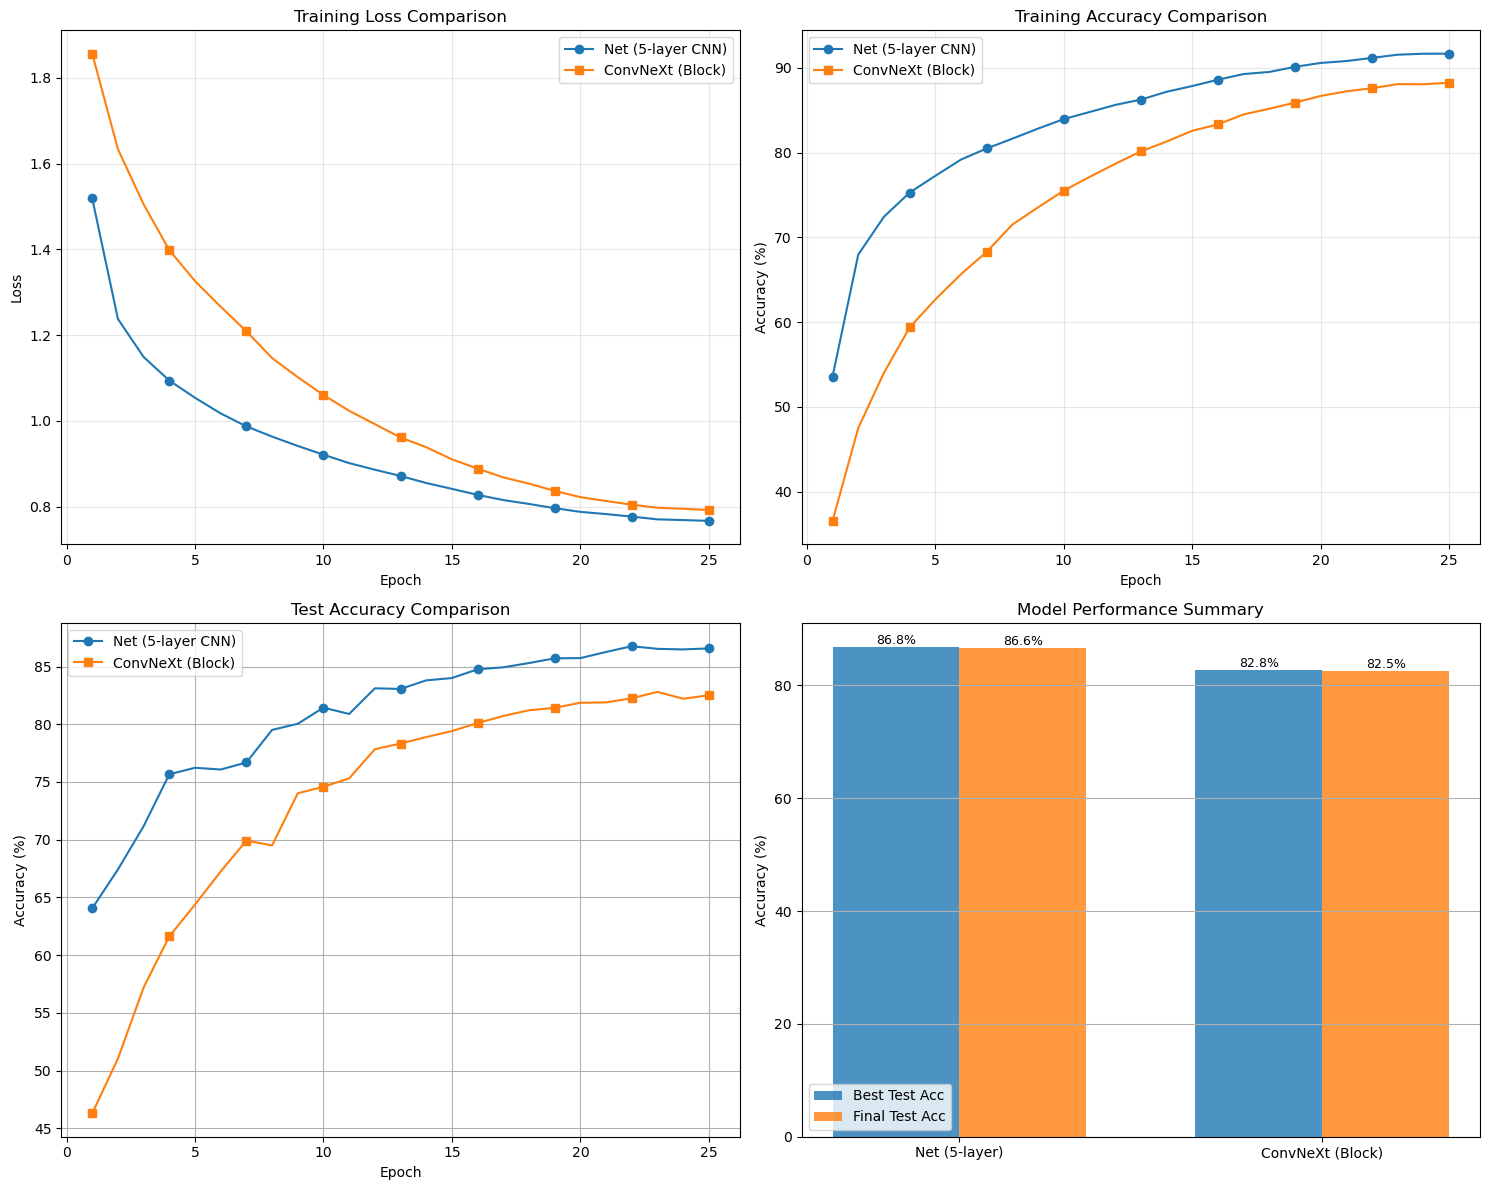


MODEL COMPARISON SUMMARY

Net (5-layer CNN):
  - Parameters: 2,475,530
  - Best Test Accuracy: 86.76%
  - Final Test Accuracy: 86.57%

ConvNeXt (Block architecture):
  - Parameters: 2,486,410
  - Best Test Accuracy: 82.80%
  - Final Test Accuracy: 82.51%

Improvement: -3.96%


In [13]:
# Compare the two models
num_epochs = len(results_net['train_losses'])
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training Loss Comparison
axes[0, 0].plot(range(1, num_epochs+1), results_net['train_losses'], label='Net (5-layer CNN)', marker='o', markevery=3)
axes[0, 0].plot(range(1, num_epochs+1), results_convnext['train_losses'], label='ConvNeXt (Block)', marker='s', markevery=3)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training Accuracy Comparison
axes[0, 1].plot(range(1, num_epochs+1), results_net['train_accuracies'], label='Net (5-layer CNN)', marker='o', markevery=3)
axes[0, 1].plot(range(1, num_epochs+1), results_convnext['train_accuracies'], label='ConvNeXt (Block)', marker='s', markevery=3)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training Accuracy Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Test Accuracy Comparison
axes[1, 0].plot(range(1, num_epochs+1), results_net['test_accuracies'], label='Net (5-layer CNN)', marker='o', markevery=3)
axes[1, 0].plot(range(1, num_epochs+1), results_convnext['test_accuracies'], label='ConvNeXt (Block)', marker='s', markevery=3)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Test Accuracy Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Summary Statistics
model_names = ['Net (5-layer)', 'ConvNeXt (Block)']
best_test_acc = [max(results_net['test_accuracies']), max(results_convnext['test_accuracies'])]
final_test_acc = [results_net['test_accuracies'][-1], results_convnext['test_accuracies'][-1]]

x = np.arange(len(model_names))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, best_test_acc, width, label='Best Test Acc', alpha=0.8)
bars2 = axes[1, 1].bar(x + width/2, final_test_acc, width, label='Final Test Acc', alpha=0.8)

axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Model Performance Summary')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(model_names)
axes[1, 1].legend()
axes[1, 1].grid(True, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('./logs/model_comparison.png', dpi=150)
plt.show()

# Print summary
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(f"\nNet (5-layer CNN):")
print(f"  - Parameters: {sum(p.numel() for p in net.parameters()):,}")
print(f"  - Best Test Accuracy: {max(results_net['test_accuracies']):.2f}%")
print(f"  - Final Test Accuracy: {results_net['test_accuracies'][-1]:.2f}%")

print(f"\nConvNeXt (Block architecture):")
print(f"  - Parameters: {sum(p.numel() for p in convnext_model.parameters()):,}")
print(f"  - Best Test Accuracy: {max(results_convnext['test_accuracies']):.2f}%")
print(f"  - Final Test Accuracy: {results_convnext['test_accuracies'][-1]:.2f}%")

improvement = max(results_convnext['test_accuracies']) - max(results_net['test_accuracies'])
print(f"\nImprovement: {improvement:+.2f}%")
print("="*60)